Sistem Rekomendasi Soal - AIZU Online Judge
======================================
Proyek 2 - 2A D4 Teknik Komputer dan Informatika

## Prerequisites

In [ ]:
!conda install scikit-learn pandas numpy keras matplotlib -y

In [ ]:
!pip install livelossplot

## Implementation

In [82]:
import keras
import keras.callbacks
import keras.layers
import keras.preprocessing.sequence
import keras.utils.np_utils
import matplotlib.pyplot
import numpy
import pandas
import sklearn
import sklearn.cluster
import sklearn.preprocessing
import livelossplot
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import math

ABILITYCHART_CSV = pandas.read_csv('abilitychart.csv')
ABILITYCHART_CSV = ABILITYCHART_CSV.set_index("userId")
ABILITYCHART_CSV = ABILITYCHART_CSV.sort_values(['solvedNum'], ascending=False)
ABILITYCHART_CSV.loc[:, "Straight Forward":"Tree"] = sklearn.preprocessing.MinMaxScaler() \
                                                                          .fit_transform(ABILITYCHART_CSV.loc[:, "Straight Forward":"Tree"])

LEARNINGPATH_CSV = pandas.read_csv('learning.csv')
LEARNINGPATH_CSV = LEARNINGPATH_CSV.loc[LEARNINGPATH_CSV['status'] == 4]
LEARNINGPATH_CSV = LEARNINGPATH_CSV.sort_values(by=['submissionDate'], ascending=[True]).drop_duplicates(subset=['userId', 'problemId'])
LEARNINGPATH_CSV = LEARNINGPATH_CSV.set_index("userId")
LEARNINGPATH_CSV = LEARNINGPATH_CSV.loc[:,'problemId']

PROBLEM_CSV = LEARNINGPATH_CSV.unique()
PROBLEM_LENGTH = len(PROBLEM_CSV)
PROBLEM_MAP_NAME_TO_INT = dict([(y, x) for x, y in enumerate(PROBLEM_CSV)])
PROBLEM_MAP_INT_TO_NAME = dict([(x, y) for x, y in enumerate(PROBLEM_CSV)])

def get_normal_user(minimal_solvedNum=100):
    return ABILITYCHART_CSV.loc[ABILITYCHART_CSV['solvedNum'] >= minimal_solvedNum] \
                           .index \
                           .unique() \
                           .values

def get_candidate_user_of_target_user(target_user):
    return LEARNINGPATH_CSV.loc[(LEARNINGPATH_CSV.index.isin(get_normal_user()) & \
                                (LEARNINGPATH_CSV.isin(LEARNINGPATH_CSV[target_user])))] \
                           .index \
                           .unique() \
                           .values

def calc_distance(x1, y1, a, b, c):
    return abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b))

def elbow_method(users, _k_range=range(1, 9)): 
    abilitychart = ABILITYCHART_CSV.loc[ABILITYCHART_CSV.index \
                                                        .isin(users), "Straight Forward":"Tree"]
    inertias = []
    for k in _k_range: 
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(abilitychart)
        inertias.append(kmeanModel.inertia_)  
    maxIndex = max(_k_range) - min(_k_range)
    # find_cons
    a = inertias[0] - inertias[maxIndex]
    b = maxIndex
    c = (1 * inertias[maxIndex]) - (maxIndex * inertias[0])
    # get_distance_of_points_from_line
    distance = []
    for k in range(max(_k_range)):
        distance.append(calc_distance(_k_range[k], inertias[k], a, b, c))
    return distance.index(max(distance)) + 1

def get_teacher_user_of_target_user(target_user):
    users = numpy.append(get_candidate_user_of_target_user(target_user), target_user)
    ability_chart = ABILITYCHART_CSV.loc[ABILITYCHART_CSV.index \
                                                         .isin(users)]
    ability_chart = pandas.DataFrame(numpy.reshape(sklearn.cluster.KMeans(init='k-means++', n_clusters=elbow_method(users)) \
                                                                  .fit_predict(ability_chart.loc[:,'Straight Forward':'Tree']),
                                                   (-1, 1)),
                                     columns=['cluster'],
                                     index=ability_chart.index.values)
    return ability_chart.loc[((ability_chart.index != target_user) &
                              (ability_chart['cluster'] == ability_chart.loc[target_user, 'cluster']))] \
                        .index \
                        .values

def get_teacher_user_learning_path_mapped(teacher_user, _timesteps_head=30):
    learning_path = LEARNINGPATH_CSV[LEARNINGPATH_CSV.index.isin(teacher_user)]
    return list(map(lambda x: list(map(lambda y: PROBLEM_MAP_NAME_TO_INT[y], 
                                       learning_path[x].unique()))[:_timesteps_head],
                    learning_path.index.unique().values))

def get_training_sample(target_user):
    train_x = []
    train_y = []
    for learning_path in get_teacher_user_learning_path_mapped(get_teacher_user_of_target_user(target_user)):
        if len(learning_path) < 2:
            continue
        train_x.append(numpy.array(learning_path[:-1]))
        train_y.append(numpy.array(learning_path[1:]))
    # add padding
    train_x = keras.preprocessing.sequence.pad_sequences(train_x, value=PROBLEM_LENGTH)
    train_y = keras.preprocessing.sequence.pad_sequences(train_y, value=PROBLEM_LENGTH)
    # reshape from (sample, timesteps) to (sample, timesteps, feature)
    train_x = numpy.array(list(map(lambda x: numpy.reshape(x, (x.shape[0], 1)), train_x)))
    train_y = numpy.array(list(map(lambda y: numpy.reshape(y, (y.shape[0], 1)), train_y)))
    return train_x, train_y

def get_lstm_model(units):
    model = keras.Sequential()
    model.add(keras.layers.Masking(mask_value=PROBLEM_LENGTH, input_shape=(None, 1)))
    model.add(keras.layers.LSTM(units, return_sequences=True))
    model.add(keras.layers.Dense(PROBLEM_LENGTH + 1))
    model.add(keras.layers.Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def visualize_model_history(model_history):
    matplotlib.pyplot.plot(model_history.history['loss'])
    matplotlib.pyplot.plot(model_history.history['val_loss'])
    matplotlib.pyplot.title('model train vs validation loss')
    matplotlib.pyplot.ylabel('loss')
    matplotlib.pyplot.xlabel('epoch')
    matplotlib.pyplot.legend(['train', 'validation'], loc='upper right')
    matplotlib.pyplot.show()

def predict(model, target_user):
    learning_path = list(map(lambda x: PROBLEM_MAP_NAME_TO_INT[x], LEARNINGPATH_CSV[target_user].values))
    next_predict = model.predict(numpy.reshape(learning_path, (1, len(learning_path), 1)))
    return list(map(lambda x: PROBLEM_MAP_INT_TO_NAME[x], numpy.setdiff1d(numpy.argsort(next_predict[-1,-1][:-1])[::-1], learning_path)))

## Evaluation

In [93]:
teachers = get_teacher_user_of_target_user('paragon')

print (teachers)
print (teachers.shape)

['rabbisland' 'aweshin' 'mits58' ... 'udon' 'ria_rai' 'quolc']
(1437,)


In [94]:
train_x, train_y = get_training_sample('paragon')

In [96]:
train_x.shape

(1437, 39, 1)

In [97]:
train_y.shape

(1437, 39, 1)

In [99]:
PROBLEM_LENGTH

2554

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Masking(mask_value=PROBLEM_LENGTH, input_shape=(None, 1)))
model.add(keras.layers.LSTM(units, return_sequences=True))
model.add(keras.layers.Dense(PROBLEM_LENGTH + 1))
model.add(keras.layers.Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

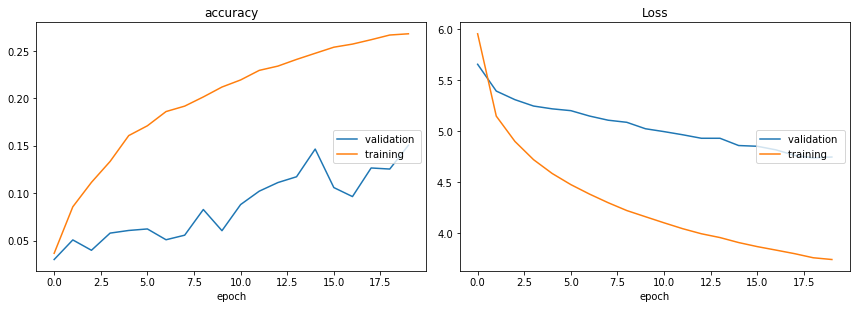

accuracy
	validation       	 (min:    0.030, max:    0.151, cur:    0.151)
	training         	 (min:    0.037, max:    0.268, cur:    0.268)
Loss
	validation       	 (min:    4.739, max:    5.657, cur:    4.747)
	training         	 (min:    3.743, max:    5.955, cur:    3.743)


In [91]:
target_user = 'paragon'

filename = None

model = get_lstm_model(1024)

if filename == None:
    train_x, train_y = get_training_sample(target_user)
    model.fit(train_x, train_y, validation_split=0.3, epochs=20, batch_size=16, callbacks = [keras.callbacks.ModelCheckpoint("checkpoint8-{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{accuracy:.4f}-{val_accuracy:.4f}.hdf5"), keras.callbacks.CSVLogger('history8.csv'), livelossplot.PlotLossesKeras()])
else:
    model.load_weights(filename)
#predict(model, target_user)

In [98]:
predict(model, 'paragon')

['10000',
 '0532',
 '0155',
 '0533',
 '1000',
 '0500',
 '1142',
 '1161',
 '0502',
 '0505',
 '0506',
 '0510',
 '0511',
 '0512',
 '0513',
 '0515',
 '0516',
 '0521',
 '1003',
 '1004',
 '1009',
 '1100',
 '1159',
 '1147',
 '1277',
 '1274',
 '1272',
 '1271',
 '2048',
 '0140',
 '1269',
 '1268',
 '0139',
 '0184',
 '0010',
 '0011',
 '0507',
 '0522',
 '0523',
 '0525',
 '1019',
 '1267',
 '10009',
 '2096',
 '1251',
 '0074',
 '0075',
 '0157',
 '0013',
 '0083',
 '0014',
 '1160',
 '1266',
 '1257',
 '1027',
 '1163',
 '0064',
 '0072',
 '0065',
 '0084',
 '0050',
 '0183',
 '0185',
 '0101',
 '0102',
 '0103',
 '0104',
 '1258',
 '0043',
 '1259',
 '1260',
 '1261',
 '1262',
 '0067',
 '1263',
 '1270',
 '0538',
 '1248',
 '1249',
 '1253',
 '1153',
 '1154',
 '1155',
 '1162',
 '1156',
 '0107',
 '0158',
 '0526',
 '1243',
 '0530',
 '1242',
 '1241',
 '1240',
 '0524',
 '1150',
 '1149',
 '0076',
 '0531',
 '1148',
 '1265',
 '1008',
 '1132',
 '0527',
 '1018',
 '0167',
 '0112',
 '1255',
 '1017',
 '1254',
 '1252',
 '1250',

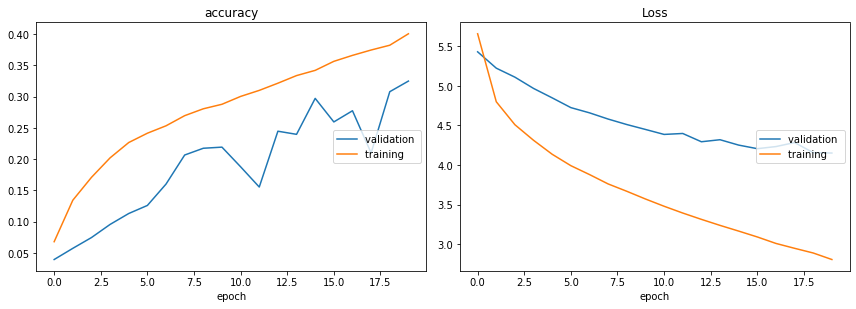

accuracy
	validation       	 (min:    0.040, max:    0.325, cur:    0.325)
	training         	 (min:    0.068, max:    0.400, cur:    0.400)
Loss
	validation       	 (min:    4.151, max:    5.432, cur:    4.151)
	training         	 (min:    2.804, max:    5.660, cur:    2.804)


In [100]:
target_user = 'paragon'

filename = None

model = get_lstm_model(1024)

if filename == None:
    train_x, train_y = get_training_sample(target_user)
    model.fit(train_x, train_y, validation_split=0.3, epochs=20, batch_size=32, callbacks = [keras.callbacks.ModelCheckpoint("checkpoint8-{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{accuracy:.4f}-{val_accuracy:.4f}.hdf5"), keras.callbacks.CSVLogger('history8.csv'), livelossplot.PlotLossesKeras()])
else:
    model.load_weights(filename)

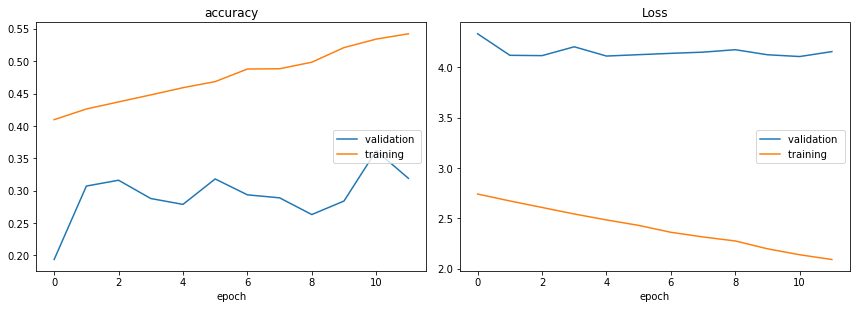

accuracy
	validation       	 (min:    0.194, max:    0.362, cur:    0.319)
	training         	 (min:    0.410, max:    0.542, cur:    0.542)
Loss
	validation       	 (min:    4.107, max:    4.332, cur:    4.156)
	training         	 (min:    2.092, max:    2.742, cur:    2.092)
Epoch 13/20
  32/1005 [..............................] - ETA: 2:48 - loss: 1.9625 - accuracy: 0.5721

In [ ]:
model.fit(train_x, train_y, validation_split=0.3, epochs=20, batch_size=32, callbacks = [keras.callbacks.ModelCheckpoint("checkpoint9-{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{accuracy:.4f}-{val_accuracy:.4f}.hdf5"), livelossplot.PlotLossesKeras()])

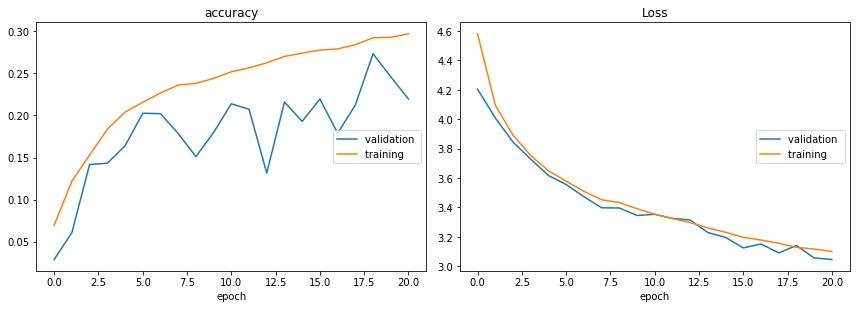

accuracy
	validation       	 (min:    0.029, max:    0.273, cur:    0.219)
	training         	 (min:    0.070, max:    0.297, cur:    0.297)
Loss
	validation       	 (min:    3.046, max:    4.204, cur:    3.046)
	training         	 (min:    3.100, max:    4.581, cur:    3.100)
Epoch 22/800
2952/4574 [==================>...........] - ETA: 5:20 - loss: 3.0771 - accuracy: 0.3022

In [ ]:
target_user = 'paragon'

filename = None

model = get_lstm_model(128)

if filename == None:
    train_x, train_y = get_training_sample(target_user)
    model.fit(train_x, train_y, validation_split=0.3, epochs=800, batch_size=8, shuffle=True, callbacks = [keras.callbacks.ModelCheckpoint("checkpoint8-{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{accuracy:.4f}-{val_accuracy:.4f}.hdf5"), keras.callbacks.CSVLogger('history8.csv'), livelossplot.PlotLossesKeras()])
else:
    model.load_weights(filename)

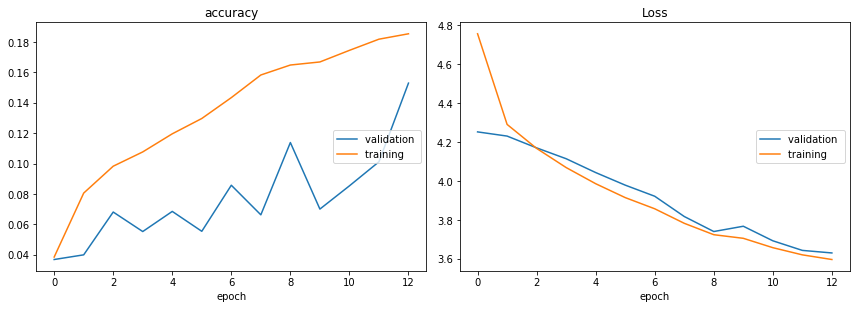

accuracy
	validation       	 (min:    0.037, max:    0.153, cur:    0.153)
	training         	 (min:    0.038, max:    0.185, cur:    0.185)
Loss
	validation       	 (min:    3.630, max:    4.252, cur:    3.630)
	training         	 (min:    3.596, max:    4.757, cur:    3.596)
Epoch 14/800
1600/4293 [==========>...................] - ETA: 1:51 - loss: 3.5855 - accuracy: 0.1933

KeyboardInterrupt: 

In [2]:
target_user = 'paragon'

filename = None

model = get_lstm_model(64)

if filename == None:
    train_x, train_y = get_training_sample(target_user)
    model.fit(train_x, train_y, validation_split=0.3, epochs=800, batch_size=8, shuffle=True, callbacks = [keras.callbacks.ModelCheckpoint("checkpoint8-{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{accuracy:.4f}-{val_accuracy:.4f}.hdf5"), keras.callbacks.CSVLogger('history8.csv'), livelossplot.PlotLossesKeras()])
else:
    model.load_weights(filename)

In [3]:
predict(model, target_user)

['10000',
 '0532',
 '0155',
 '0533',
 '1000',
 '0500',
 '1142',
 '1161',
 '0502',
 '0505',
 '0506',
 '0510',
 '0511',
 '0512',
 '0513',
 '0515',
 '0516',
 '0521',
 '1003',
 '1004',
 '1009',
 '1100',
 '1159',
 '1147',
 '1277',
 '1274',
 '1272',
 '1271',
 '2048',
 '0140',
 '1269',
 '1268',
 '0139',
 '0184',
 '0010',
 '0011',
 '0507',
 '0522',
 '0523',
 '0525',
 '1019',
 '1267',
 '10009',
 '2096',
 '1251',
 '0074',
 '0075',
 '0157',
 '0013',
 '0083',
 '0014',
 '1160',
 '1266',
 '1257',
 '1027',
 '1163',
 '0064',
 '0072',
 '0065',
 '0084',
 '0050',
 '0183',
 '0185',
 '0101',
 '0102',
 '0103',
 '0104',
 '1258',
 '0043',
 '1259',
 '1260',
 '1261',
 '1262',
 '0067',
 '1263',
 '1270',
 '0538',
 '1248',
 '1249',
 '1253',
 '1153',
 '1154',
 '1155',
 '1162',
 '1156',
 '0107',
 '0158',
 '0526',
 '1243',
 '0530',
 '1242',
 '1241',
 '1240',
 '0524',
 '1150',
 '1149',
 '0076',
 '0531',
 '1148',
 '1265',
 '1008',
 '1132',
 '0527',
 '1018',
 '0167',
 '0112',
 '1255',
 '1017',
 '1254',
 '1252',
 '1250',